In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

In [2]:
# 导入训练集，测试集
df_train = pd.read_csv('input/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('input/test.csv', encoding="ISO-8859-1")

In [3]:
# 导入产品介绍
df_desc = pd.read_csv('input/product_descriptions.csv')

In [4]:
df_train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [5]:
df_desc.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [6]:
# 合并训练集，测试集
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [7]:
df_all.head()

,id,product_title,product_uid,relevance,search_term
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet


In [8]:
df_all.shape

(240760, 5)

In [9]:
# 把产品介绍合并进数据全集
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')

In [10]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...


In [11]:
# 文本预处理
# 此处用简单的Stem做个例子(词干提取)
# 还可以：去掉停止词，纠正拼写，去掉数字，去掉各种emoji，等等
stemmer = SnowballStemmer('english')

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [12]:
# 计算“关键词”的有效性，可以之间看“出现了多少次”
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

In [13]:
# 把每一列都跑一遍，清洁所有数据
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))

In [14]:
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

In [15]:
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

In [16]:
# 自制文本特征
# 只要靠谱，随意增加特征

# 增加关键词长度特征
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

In [17]:
# 增加标题中有多少关键词重合特征
df_all['commons_in_title'] = df_all.apply(lambda x:str_common_word(x['search_term'],x['product_title']), axis=1)

In [18]:
# 增加描述中有多少关键词重合特征
df_all['commons_in_desc'] = df_all.apply(lambda x:str_common_word(x['search_term'],x['product_description']), axis=1)

In [19]:
# 把模型不能处理的原特征drop掉
df_all = df_all.drop(['search_term','product_title','product_description'],axis=1)

In [20]:
### 分开训练集和测试集
df_train = df_all.loc[df_train.index]
df_test = df_all.loc[df_test.index]

In [21]:
# 记录下测试集的id
test_ids = df_test['id']

In [22]:
# 分离出y_train
y_train = df_train['relevance'].values

In [23]:
# 删除原数据的label
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

In [24]:
# 建立模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [25]:
# 5折交叉验证
params = [1,3,5,6,7,8,9,10]
test_scores = []
for param in params:
    clf = RandomForestRegressor(n_estimators=30, max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

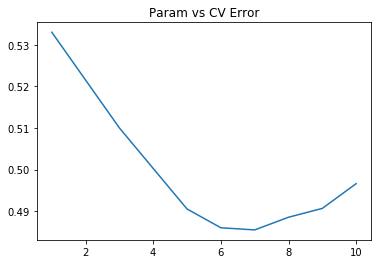

In [26]:
# 画个图看看
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error");

In [27]:
# 测试出的最优解建立模型，并跑测试集
rf = RandomForestRegressor(n_estimators=30, max_depth=7)

In [28]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
y_pred = rf.predict(X_test)

In [31]:
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('input/submission.csv',index=False)

In [32]:
# 可以尝试修改/调试/升级的部分是：
# 1,文本预处理步骤: 你可以使用很多不同的方法来使得文本数据变得更加清洁
# 2,自制的特征: 相处更多的特征值表达方法（关键词全段重合数量，重合比率，等等）
# 3,更好的回归模型: 根据Ensemble方法，把分类器提升到极致

In [34]:
df_test = pd.read_csv('input/test.csv', encoding="ISO-8859-1")
test_ids = df_test['id']

In [35]:
pd.DataFrame({"id": test_ids, "relevance": y_pred}).to_csv('input/submission.csv',index=False)